# Tarea 6:

## Redes Neuronales Multicapas

In [1]:
import sys
print(sys.executable)


D:\aprendizaje-automatico\lib-anaconda\python.exe


In [223]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

En está tarea van a crear una Red Neuronal Multicapa para el conjunto de datos `FashionMIST` usando como base el notebook `20-RedesNeuronales-1.ipynb`. Deben usar una arquitectura diferente a la del notebook.

Fecha de entrega: jueves 17 de Octubre (antes de la hora de clase)

### Importar datos

In [224]:
SEMILLA = 18

random.seed(SEMILLA)
np.random.seed(SEMILLA)
torch.manual_seed(SEMILLA)
torch.cuda.manual_seed(SEMILLA)
torch.backends.cudnn.deterministic = True

In [225]:
RAIZ = '../datos'

train_data = datasets.FashionMNIST(root=RAIZ,
                                   train=True,     # Cargar el conjunto de entrenamiento
                                   download=True,  # Descargar los datos si no están
                                   transform=transforms.ToTensor())  # Transformar las imágenes a tensores

In [226]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../datos
    Split: Train
    StandardTransform
Transform: ToTensor()

### Normalizar la data

In [227]:
media = train_data.data.float().mean() / 255
desviacion_estandar = train_data.data.float().std() / 255
print(f'Media calculada: {media}')
print(f'Desviación estándar calculada: {desviacion_estandar}')

Media calculada: 0.2860405743122101
Desviación estándar calculada: 0.35302427411079407


### Transformaciones

In [228]:
transfomaciones_entrenamiento = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[media], std=[desviacion_estandar])
                                      ])

transformaciones_prueba = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[media], std=[desviacion_estandar])
                                     ])

### Cargar datos de entrenamientos

In [229]:
data_entrenamiento = datasets.FashionMNIST(root=RAIZ,
                            train=True,
                            download=True,
                            transform=transfomaciones_entrenamiento)

data_prueba = datasets.FashionMNIST(root=RAIZ,
                           train=False,
                           download=True,
                           transform=transformaciones_prueba)

In [230]:
def visualizar_imagenes(imagenes):

    n_imagenes = len(imagenes)

    filas = int(np.sqrt(n_imagenes))
    columnas = int(np.sqrt(n_imagenes))

    fig = plt.figure()
    for i in range(filas*columnas):
        ax = fig.add_subplot(filas, columnas, i+1)
        ax.imshow(imagenes[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

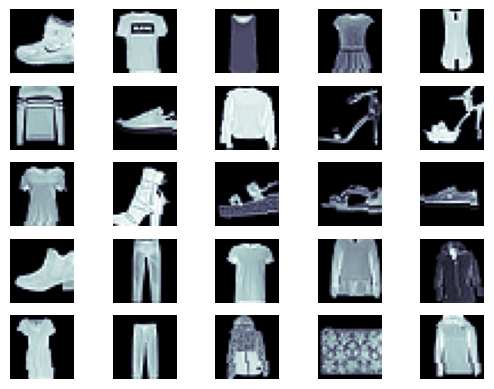

In [231]:
N_IMAGENES = 25

imagenes = [imagen for imagen, etiqueta in [data_entrenamiento[i] for i in range(N_IMAGENES)]]

visualizar_imagenes(imagenes)

In [232]:
PROPORCION_VALIDACION = 0.9

n_ejemplos_entrenamiento = int(len(data_entrenamiento) * PROPORCION_VALIDACION)
n_ejemplos_validacion = len(data_entrenamiento) - n_ejemplos_entrenamiento

In [233]:
data_entrenamiento, data_validacion = data.random_split(data_entrenamiento,
                                           [n_ejemplos_entrenamiento, n_ejemplos_validacion])

In [234]:
print(f'Número de ejemplos de entrenamiento: {len(data_entrenamiento)}')
print(f'Número de ejemplos de validación: {len(data_validacion)}')
print(f'Número de ejemplos de prueba: {len(data_prueba)}')

Número de ejemplos de entrenamiento: 54000
Número de ejemplos de validación: 6000
Número de ejemplos de prueba: 10000


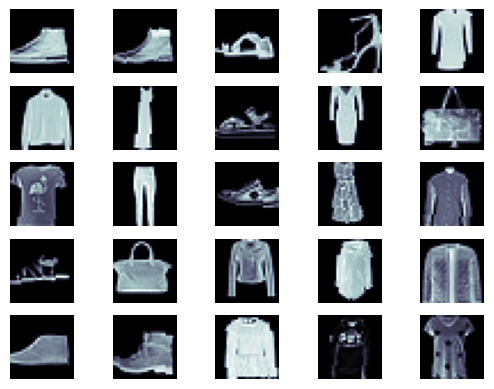

In [235]:
N_IMAGENES = 25

imagenes = [imagen for imagen, etiqueta in [data_validacion[i] for i in range(N_IMAGENES)]]

visualizar_imagenes(imagenes)

In [236]:
data_validacion = copy.deepcopy(data_validacion)
data_validacion.dataset.transform = transformaciones_prueba

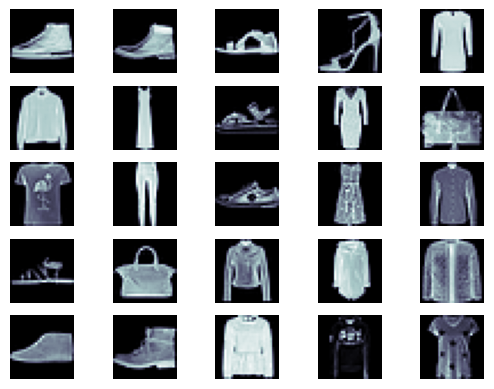

In [237]:
N_IMAGENES = 25

imagenes = [imagen for imagen, etiqueta in [data_validacion[i] for i in range(N_IMAGENES)]]

visualizar_imagenes(imagenes)

In [238]:
TAMAÑO_LOTE = 64

iterador_entrenamiento = data.DataLoader(data_entrenamiento,
                                 shuffle=True,
                                 batch_size=TAMAÑO_LOTE)

iterador_validacion = data.DataLoader(data_validacion,
                                 batch_size=TAMAÑO_LOTE)

iterador_prueba = data.DataLoader(data_prueba,
                                batch_size=TAMAÑO_LOTE)

### Defincion del modelo

1) Capa de entrada (784 neuronas): Corresponde a la aplanación de las imágenes de 28x28 píxeles en un vector de 784 características.
2) Primera capa oculta (512 neuronas): Se elige un número grande para capturar patrones complejos de las imágenes de entrada.
3) Segunda capa oculta (256 neuronas): Se reduce el número de neuronas para extraer características más abstractas de la capa anterior.
4) Tercera capa oculta (128 neuronas): Continúa la reducción para enfocarse en representaciones generales y reducir la dimensionalidad.
5) Capa de salida (10 neuronas): Coincide con las 10 clases de FashionMNIST, con cada neurona prediciendo una clase diferente.
   
La estructura piramidal ayuda a capturar patrones relevantes mientras reduce el riesgo de sobreajuste y mejora la eficiencia.

In [239]:

class MLP(nn.Module):
    def __init__(self, dim_entrada, dim_salida):
        super(MLP, self).__init__()

        # Capa de entrada: 784 neuronas (28*28 píxeles)
        self.fc_entrada = nn.Linear(dim_entrada, 512)
        # Capa oculta: 512 neuronas
        self.fc_oculta1 = nn.Linear(512, 256)
        # Segunda capa oculta: 256 neuronas
        self.fc_oculta2 = nn.Linear(256, 128)
        # Capa de salida: 10 neuronas (una para cada clase)
        self.fc_salida = nn.Linear(128, dim_salida)

    def forward(self, x):
        # x: [tamaño_lote, 1, 28, 28] (1 canal para imágenes en escala de grises)
        
        # Aplanar la entrada a tamaño_lote x 784 (28x28)
        tamaño_lote = x.size(0)
        x = x.view(tamaño_lote, -1)

        # Paso por la primera capa oculta con activación ReLU
        o_1 = F.relu(self.fc_entrada(x))
        
        # Paso por la segunda capa oculta con activación ReLU
        o_2 = F.relu(self.fc_oculta1(o_1))
        
        # Paso por la tercera capa oculta con activación ReLU
        o_3 = F.relu(self.fc_oculta2(o_2))
        
        # Capa de salida sin función de activación (los logits se pasan a CrossEntropyLoss)
        y_pred = self.fc_salida(o_3)

        return y_pred



In [240]:
DIM_ENTRADA = 28 * 28
DIM_SALIDA = 10

modelo = MLP(DIM_ENTRADA, DIM_SALIDA)

In [241]:
def countar_parametros(modelo):
    return sum(p.numel() for p in modelo.parameters() if p.requires_grad)

In [242]:
print(f'El modelo tiene {countar_parametros(modelo):,} parámetros entrenables ')

El modelo tiene 567,434 parámetros entrenables 


In [243]:
optimizador = optim.Adam(modelo.parameters())

In [244]:
criterio = nn.CrossEntropyLoss()

In [245]:
# dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dispositivo = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [246]:
modelo = modelo.to(dispositivo)
criterion = criterio.to(dispositivo)

In [247]:
def calcular_exactitud(y_pred, y):
    mayor_pred = y_pred.argmax(1, keepdim=True)
    correcta = mayor_pred.eq(y.view_as(mayor_pred)).sum()
    exactitud = correcta.float() / y.shape[0]
    return exactitud

In [248]:
def entrenar(modelo, iterador, optimizador, criterio, dispositivo):

    perdida_epoca = 0
    exactitud_epoca = 0

    modelo.train()

    for (x, y) in tqdm(iterador, desc="Entrenamiento", leave=False):

        x = x.to(dispositivo)
        y = y.to(dispositivo)

        optimizador.zero_grad()

        y_pred = modelo(x)

        perdida = criterio(y_pred, y)

        exactitud = calcular_exactitud(y_pred, y)

        perdida.backward()

        optimizador.step()

        perdida_epoca += perdida.item()
        exactitud_epoca += exactitud.item()

    return perdida_epoca / len(iterador), exactitud_epoca / len(iterador)

In [249]:
def evaluar(modelo, iterador, criterio, dispositivo):

    perdida_epoca = 0
    exactitud_epoca = 0

    modelo.eval()

    with torch.inference_mode():

        for (x, y) in tqdm(iterador, desc="Evaluando", leave=False):

            x = x.to(dispositivo)
            y = y.to(dispositivo)

            y_pred = modelo(x)

            perdida = criterio(y_pred, y)

            exactitud = calcular_exactitud(y_pred, y)

            perdida_epoca += perdida.item()
            exactitud_epoca += exactitud.item()

    return perdida_epoca / len(iterador), exactitud_epoca / len(iterador)

In [250]:
def duracion_epoca(tiempo_inicio, tiempo_final):
    tiempo_transcurrido = tiempo_final - tiempo_inicio
    mins_transcurrido = int(tiempo_transcurrido / 60)
    segs_transcurrido = int(tiempo_transcurrido - (mins_transcurrido * 60))
    return mins_transcurrido, segs_transcurrido

In [251]:
EPOCAS = 10

mejor_perdida_validacion = float('inf')

for epoca in trange(EPOCAS):

    tiempo_inicio = time.monotonic()

    perdida_entrenamiento, exactitud_entrenamiento = entrenar(modelo, iterador_entrenamiento, optimizador, criterio, dispositivo)
    perdida_validacion, exactitud_validacion = evaluar(modelo, iterador_validacion, criterio, dispositivo)

    if perdida_validacion < mejor_perdida_validacion:
        mejor_perdida_validacion = perdida_validacion
        torch.save(modelo.state_dict(), 'tut1-modelo.pt')

    tiempo_final = time.monotonic()

    mins_epoca, secs_epoca = duracion_epoca(tiempo_inicio, tiempo_final)

    print(f'Epoca: {epoca+1:02} | Tiempo Epoca: {mins_epoca}m {secs_epoca}s')
    print(f'\t Perdida Entrenamiento: {perdida_entrenamiento:.3f} | Exactitud Entrenamiento: {exactitud_entrenamiento*100:.2f}%')
    print(f'\t Perdida Validacion: {perdida_validacion:.3f} |  Exactitud Validacion: {exactitud_validacion*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 01 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.663 | Exactitud Entrenamiento: 74.75%
	 Perdida Validacion: 0.515 |  Exactitud Validacion: 80.26%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 02 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.517 | Exactitud Entrenamiento: 80.76%
	 Perdida Validacion: 0.451 |  Exactitud Validacion: 82.64%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 03 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.470 | Exactitud Entrenamiento: 82.50%
	 Perdida Validacion: 0.419 |  Exactitud Validacion: 83.95%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 04 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.443 | Exactitud Entrenamiento: 83.32%
	 Perdida Validacion: 0.423 |  Exactitud Validacion: 84.20%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 05 | Tiempo Epoca: 0m 24s
	 Perdida Entrenamiento: 0.428 | Exactitud Entrenamiento: 83.92%
	 Perdida Validacion: 0.377 |  Exactitud Validacion: 86.20%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 06 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.412 | Exactitud Entrenamiento: 84.56%
	 Perdida Validacion: 0.382 |  Exactitud Validacion: 86.04%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 07 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.401 | Exactitud Entrenamiento: 84.88%
	 Perdida Validacion: 0.355 |  Exactitud Validacion: 87.07%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 08 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.390 | Exactitud Entrenamiento: 85.49%
	 Perdida Validacion: 0.368 |  Exactitud Validacion: 85.87%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 09 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.381 | Exactitud Entrenamiento: 85.77%
	 Perdida Validacion: 0.362 |  Exactitud Validacion: 86.66%


Entrenamiento:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoca: 10 | Tiempo Epoca: 0m 23s
	 Perdida Entrenamiento: 0.377 | Exactitud Entrenamiento: 85.85%
	 Perdida Validacion: 0.362 |  Exactitud Validacion: 86.86%


In [252]:
modelo.load_state_dict(torch.load('tut1-modelo.pt'))

perdida_prueba, exactitud_prueba = evaluar(modelo, iterador_prueba, criterio, dispositivo)

C:\Users\kikez\AppData\Local\Temp\ipykernel_29564\525063720.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo.load_state_dict(torch.load('tut1-modelo.pt'))


Evaluando:   0%|          | 0/157 [00:00<?, ?it/s]

In [253]:
print(f'Perdida Prueba: {perdida_prueba:.3f} | Exactitud Prueba: {exactitud_prueba*100:.2f}%')

Perdida Prueba: 0.373 | Exactitud Prueba: 86.53%


### Examinando el Modelo

In [254]:
def obtener_predicciones(modelo, iterador, dispositivo):

    modelo.eval()

    imagenes = []
    etiquetas = []
    probabilidades = []

    with torch.no_grad():

        for (x, y) in iterador:

            x = x.to(dispositivo)

            y_pred = modelo(x)

            y_prob = F.softmax(y_pred, dim=-1)

            imagenes.append(x.cpu())
            etiquetas.append(y.cpu())
            probabilidades.append(y_prob.cpu())

    imagenes = torch.cat(imagenes, dim=0)
    etiquetas = torch.cat(etiquetas, dim=0)
    probabilidades = torch.cat(probabilidades, dim=0)

    return imagenes, etiquetas, probabilidades

In [255]:
imagenes, etiquetas, probabilidades = obtener_predicciones(modelo, iterador_prueba, dispositivo)

etiquetas_predichas = torch.argmax(probabilidades, 1)

In [256]:
def graficar_matriz_confusion(etiquetas, etiquetas_predichas):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(etiquetas, etiquetas_predichas)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

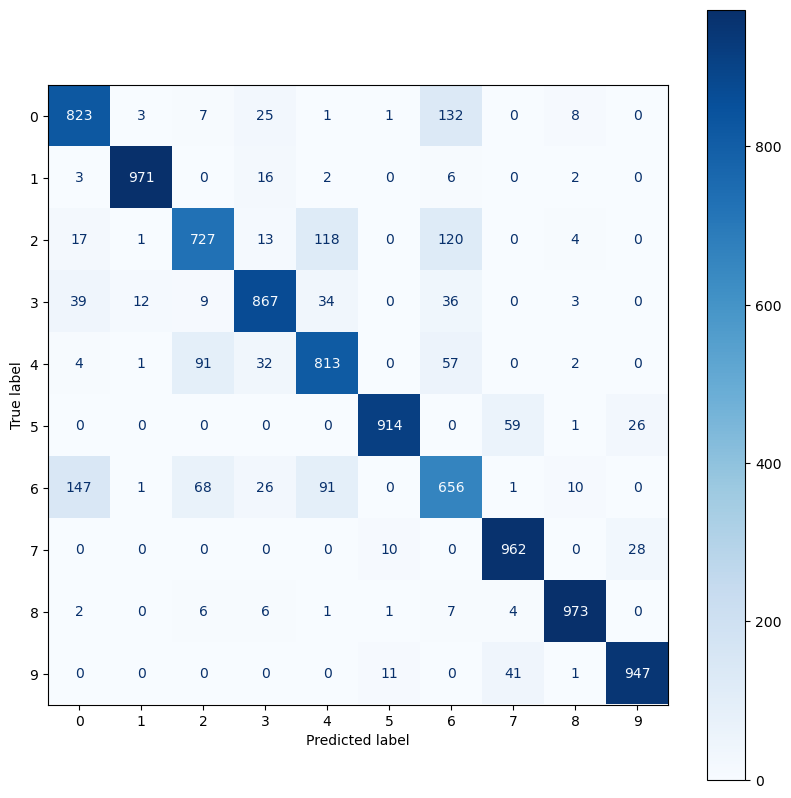

In [257]:
graficar_matriz_confusion(etiquetas, etiquetas_predichas)

In [258]:
correctos = torch.eq(etiquetas, etiquetas_predichas)
correctos.sum()

tensor(8653)

In [259]:
ejemplos_incorrectos = []

for imagen, etiqueta, probabilidad, correcto in zip(imagenes, etiquetas, probabilidades, correctos):
    if not correcto:
        ejemplos_incorrectos.append((imagen, etiqueta, probabilidad))

ejemplos_incorrectos.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [260]:
def graficar_mas_incorrectos(incorrectos, n_imagenes):

    filas = int(np.sqrt(n_imagenes))
    columnas = int(np.sqrt(n_imagenes))

    fig = plt.figure(figsize=(20, 10))
    for i in range(filas*columnas):
        ax = fig.add_subplot(filas, columnas, i+1)
        imagen, etiqueta_real, probabilidades = incorrectos[i]
        probabilidad_real = probabilidades[etiqueta_real]
        probabilidad_incorrecta, etiqueta_incorrecta = torch.max(probabilidades, dim=0)
        ax.imshow(imagen.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'etiqueta real: {etiqueta_real} ({probabilidad_real:.3f})\n'
                     f'etiqueta predicha: {etiqueta_incorrecta} ({probabilidad_incorrecta:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

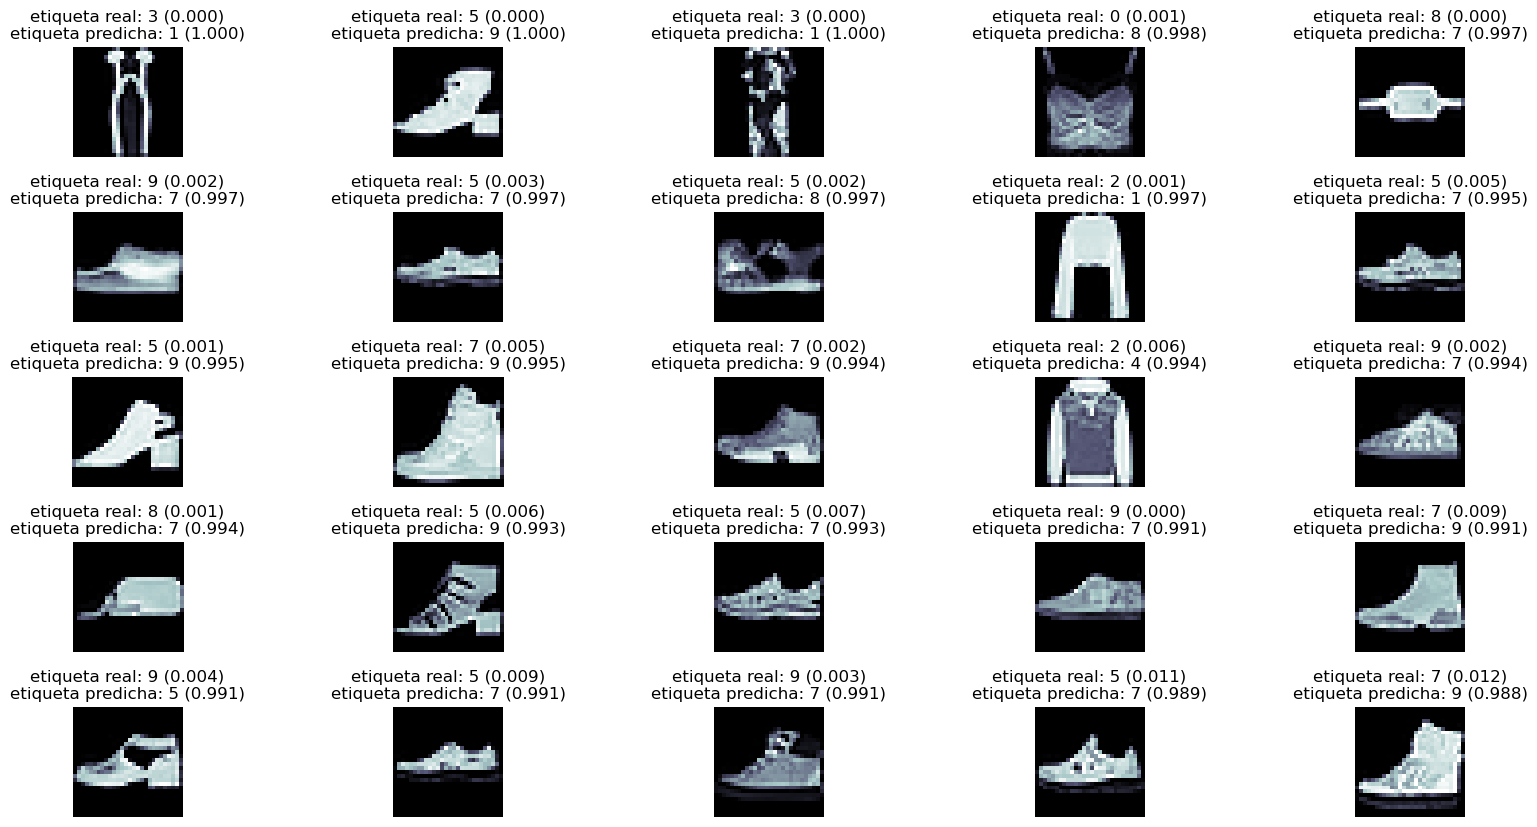

In [261]:
N_IMAGENES = 25

graficar_mas_incorrectos(ejemplos_incorrectos, N_IMAGENES)